In [1]:
import numpy as np
import torch
from binomial_fns import binomial, binomln
from scipy.stats import wasserstein_distance
from scipy.special import gammaln, gamma
import matplotlib.pyplot as plt
from poisson_process_utils import sample_poisson_process_from_exp, sample_poisson_process

In [2]:
def exp_was_dist(n, m, lambda1, lambda2):
    val1 = 0
    log_pstr1 = np.log(lambda1) - np.log(lambda1 + lambda2)
    log_pstr2 = np.log(lambda2) - np.log(lambda1 + lambda2)
    for k in range((n + m) + 1):
        val1 += np.exp(binomln(n + m, k) + k*log_pstr1 + (n + m - k)*log_pstr2)*np.abs(n - k)
    val_test7 = val1*(1/lambda1 + 1/lambda2)
    return val_test7

def std_was_dist(n, m, lambda1, lambda2):
    var = n*(n+1)/lambda1**2 + m*(m+1)/lambda2**2 - 2*n*m/lambda1/lambda2 \
    - exp_was_dist(n, m, lambda1, lambda2)**2
    return np.sqrt(var)

In [3]:
def exp_was_dist_unif_order_stat(N, k, lambda1, lambda2):
    val = 0
    u1 = N/lambda1
    u2 = N/lambda2
    for i in range(N+1):
        for j in range(N+1):
            val += (-1)**(i+j)*np.exp(binomln(N-k, i) + binomln(N-k, j)) * \
            (2/(i+k)/(i+k+1)/(2*k+i+j+1) * np.exp((k+i)*np.log(lambda1/lambda2))*u2 - u2/(i+k)/(j+k+1) + u1/(i+k+1)/(j+k))
    val *= (N*binomial(N-1, k-1))**2
    return val

In [4]:
def exp_was_dist_first_spike_deltat(dt, lambda1, lambda2):
    return np.exp(-dt) * (lambda1**2 + lambda2**2) / (lambda1*lambda2) / (lambda1+lambda2)\
    + dt + (1-np.exp(-dt))*(1/lambda1 - 1/lambda2)

def exp_was_dist_first_spike_deltat_v2(dt, lambda1, lambda2):
    p = np.exp(-lambda2*dt)
    return p / (lambda1+lambda2)*(lambda1**2 + lambda2**2)/(lambda1*lambda2) \
    + dt + (1-p)*(1/lambda1 - 1/lambda2)

def exp_was_dist_first_spike_deltat_v3(dt, lambda1, lambda2):
    p = np.exp(-lambda2*dt)
    return (1/lambda1 - 1/lambda2 + dt) * (1-2*p) + 2*p *(lambda2/lambda1 / (lambda1+lambda2) + dt)


def exp_was_dist_deltat(dt, k, l, lambda1, lambda2):
    p = np.exp(-lambda2*dt)
    val0 = 0
    for j in range(l):
        val0 += np.exp(j*np.log(lambda2*dt) - gammaln(j+1))
    val1 = (k/lambda1 - l/lambda2 + dt) * (1 - 2*p*val0)

    val2 = 0
    for i in range(k):
        for j in range(l):
            val2 += (k-i) * np.exp(binomln(i+j, i) + (l-1-j)*np.log(lambda2*dt) - gammaln(l-j) \
                                   + (i-1)*np.log(lambda1) + (j+1)*np.log(lambda2) - (i+j+1)*np.log(lambda1+lambda2))
    val3 = 2*p*(val2 + dt*np.exp((l-1)*np.log(lambda2*dt) - gammaln(l)))

    return val1 + val3

def std_was_dist_deltat(dt, k, l, lambda1, lambda2):
    mean = exp_was_dist_deltat(dt, k, l, lambda1, lambda2)
    return np.sqrt(k/lambda1**2 + (k/lambda1)**2 + l/lambda2**2 + (l/lambda2)**2 + dt**2 \
                   + 2*dt*(k/lambda1 - l/lambda2) - 2*k*l/lambda1/lambda2 \
                   - mean**2)

In [5]:
import math
def one_dim_Wass_dist_analytic(rate1, rate2, k):
    dist = 0
    p = rate1 / (rate1 + rate2)
    for i in range(2*k+1):
        dist += math.comb(2*k,i) * p**i*(1-p)**(2*k-i)*np.abs(i-(2*k-i))
    return dist * (rate1 + rate2) / 2 / rate1 / rate2

In [6]:
#lambda1 = 0.5
#lambdas = [0.2, 0.3, 0.5, 0.6, 0.7, 0.8]
lambda1 = 0.3
lambdas = [0.8]

derivs = []
cdfs = []
empiricals = []

n = 20000
datanum1 = 100; datanum2 = 100

for lambda2 in lambdas:
    
    p1 = datanum1/lambda1; p2 = datanum2/lambda2;
    
    Was_dists = []
    for n in range(datanum1):
        Was_dist = exp_was_dist(n + 1, n + 1, lambda1, lambda2)
        Was_dists.append(Was_dist)
    
    Was_sum = np.sum(Was_dists) / (datanum1)
    cdf_sum = np.abs(p1-p2)/2
    empirical_sum = 0.0
    
    for n in range(datanum1):
        data1 = (torch.rand(datanum1, device='cuda')*p1)
        data2 = (torch.rand(datanum2, device='cuda')*p2)
    
        data_diff = torch.abs(torch.sort(data1).values - torch.sort(data2).values).cpu().numpy()
        
        empirical_sum += (np.sum(data_diff) / datanum1)
    empirical_sum /= n
    
    derivs.append(Was_sum)
    cdfs.append(cdf_sum)
    empiricals.append(empirical_sum)
    


In [7]:
# generate data
datanum1 = 1000; datanum2 = 1000
p1 = datanum1/lambda1; p2 = datanum2/lambda2;
data1 = (torch.rand(datanum1, device='cuda')*p1)
data2 = (torch.rand(datanum2, device='cuda')*p2)

In [8]:
%matplotlib inline

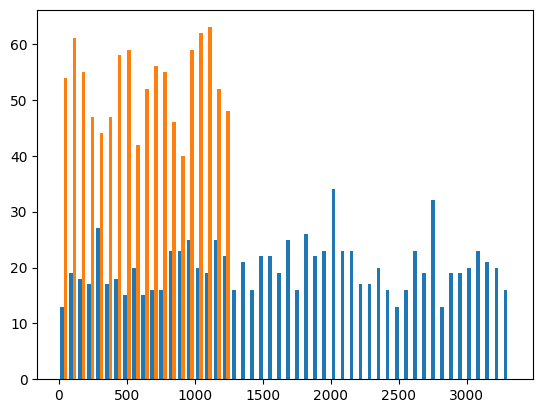

In [9]:
plt.hist((data1.to('cpu'),data2.to('cpu')), bins=50)
plt.show()

In [10]:
def exp_was_dist(n, m, lambda1, lambda2):
    val1 = 0
    log_pstr1 = np.log(lambda1) - np.log(lambda1 + lambda2)
    log_pstr2 = np.log(lambda2) - np.log(lambda1 + lambda2)
    for k in range((n + m) + 1):
        val1 += np.exp(binomln(n + m, k) + k*log_pstr1 + (n + m - k)*log_pstr2)*np.abs(n - k)
    val_test7 = val1*(1/lambda1 + 1/lambda2)
    return val_test7

In [11]:
lambda1 = 0.3
lambda2 = 0.8
N = 20
datanum1 = N

Was_dists = []
Was_dist_stds = []


unif_Was_dists = []

for n in range(datanum1):
    Was_dist = exp_was_dist(n + 1, n + 1, lambda1, lambda2)
    Was_dist_std = std_was_dist(n + 1, n + 1, lambda1, lambda2)
    unif_Was_dist = exp_was_dist_unif_order_stat(datanum1, n+1, lambda1, lambda2)
    Was_dists.append(Was_dist)
    Was_dist_stds.append(Was_dist_std)
    unif_Was_dists.append(unif_Was_dist)

In [12]:
#unif_Was_dists

In [13]:
lambda1 = 0.3
lambda2 = 0.8
# generate data
datanum1 = N; datanum2 = N

p1 = datanum1/lambda1; p2 = datanum2/lambda2;

n_trials = 20000
data_diffs = []
for t in range(n_trials):
    data1 = (torch.rand(datanum1, device='cuda')*p1)
    data2 = (torch.rand(datanum2, device='cuda')*p2)
    data_diff = torch.abs(torch.sort(data1).values - torch.sort(data2).values).cpu().numpy()
    data_diffs.append(data_diff)
data_diffs_np = np.array(data_diffs)
data_diffs_mean = np.mean(data_diffs_np, axis=0)
data_diffs_std = np.std(data_diffs_np, axis=0)

In [14]:
# generate data
datanum1 = N; datanum2 = N

p1 = datanum1/lambda1; p2 = datanum2/lambda2;

n_trials = 20000
data_diffs_pois = []
data_diffs_pois2 = []
for t in range(n_trials):
    data1 = sample_poisson_process(rate=lambda1, window_size=5*p1)[:datanum1]
    data2 = sample_poisson_process(rate=lambda2, window_size=5*p2)[:datanum2]
    data_diff = np.abs(data1 - data2)
    data_diffs_pois.append(data_diff)
    data1_ = sample_poisson_process_from_exp(rate=lambda1, window_size=5*p1)[:datanum1]
    data2_ = sample_poisson_process_from_exp(rate=lambda2, window_size=5*p2)[:datanum2]
    data_diff_ = np.abs(data1_ - data2_)
    data_diffs_pois2.append(data_diff_)
data_diffs_pois_np = np.array(data_diffs_pois)
data_diffs_pois_mean = np.mean(data_diffs_pois_np, axis=0)
data_diffs_pois_std = np.std(data_diffs_pois_np, axis=0)
data_diffs_pois2_np = np.array(data_diffs_pois2)
data_diffs_pois2_mean = np.mean(data_diffs_pois2_np, axis=0)
data_diffs_pois2_std = np.std(data_diffs_pois2_np, axis=0)

In [15]:
# generate data
datanum1 = N; datanum2 = N

p1 = datanum1/lambda1; p2 = datanum2/lambda2;
deltats = np.linspace(-10, 10, 101)
n_trials = 20000
data_diffs_pois_deltats = []
data_diffs_pois2_deltats = []
for t in range(n_trials):
    data1 = sample_poisson_process(rate=lambda1, window_size=5*p1)[:datanum1]
    data2 = sample_poisson_process(rate=lambda2, window_size=5*p2)[:datanum2]
    data1_ = sample_poisson_process_from_exp(rate=lambda1, window_size=5*p1)[:datanum1]
    data2_ = sample_poisson_process_from_exp(rate=lambda2, window_size=5*p2)[:datanum2]
    data_diffs_pois_deltat = []
    data_diffs_pois2_deltat = []
    for delta in deltats:
        data_diff = np.abs(data1[:,np.newaxis] + delta - data2[np.newaxis,:])
        data_diffs_pois_deltat.append(data_diff)
        data_diff_ = np.abs(data1_[:,np.newaxis] + delta - data2_[np.newaxis,:])
        data_diffs_pois2_deltat.append(data_diff_)
    data_diffs_pois_deltats.append(data_diffs_pois_deltat)
    data_diffs_pois2_deltats.append(data_diffs_pois2_deltat)
data_diffs_pois_deltats_np = np.array(data_diffs_pois_deltats)
data_diffs_pois_deltats_mean = np.mean(data_diffs_pois_deltats_np, axis=0)
data_diffs_pois_deltats_std = np.std(data_diffs_pois_deltats_np, axis=0)
data_diffs_pois2_deltats_np = np.array(data_diffs_pois2_deltats)
data_diffs_pois2_deltats_mean = np.mean(data_diffs_pois2_deltats_np, axis=0)
data_diffs_pois2_deltats_std = np.std(data_diffs_pois2_deltats_np, axis=0)

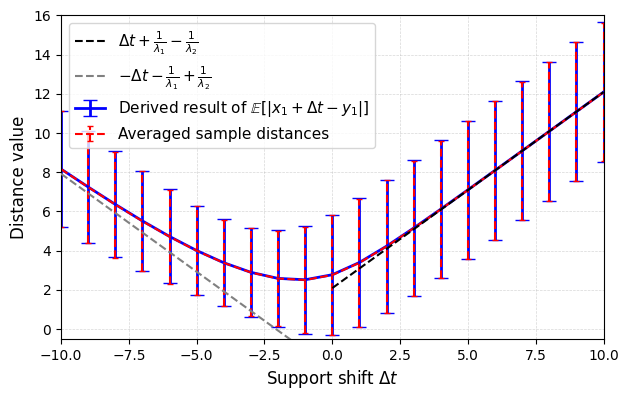

In [16]:
plt.figure(figsize=(7,4.2))
deltats_positive2 = np.linspace(0,10,11)
deltats_positive = deltats_positive2[1:]
idx0 = 0
idx1 = 0

data_diffs_pois_deltats_analytic_v5 = exp_was_dist_deltat(deltats_positive, idx0+1, idx1+1, lambda1, lambda2)
data_diffs_pois_deltats_analytic_v5_rev = exp_was_dist_deltat(deltats_positive, idx1+1, idx0+1, lambda2, lambda1)

data_diffs_pois_deltats_analytic_v5_std = std_was_dist_deltat(deltats_positive, idx0+1, idx1+1, lambda1, lambda2)
data_diffs_pois_deltats_analytic_v5_rev_std = std_was_dist_deltat(deltats_positive, idx1+1, idx0+1, lambda2, lambda1)

eb1 = plt.errorbar(np.concatenate([-deltats_positive[::-1], [0], deltats_positive[:]]), 
             np.concatenate([data_diffs_pois_deltats_analytic_v5_rev[::-1], [Was_dists[idx0]], data_diffs_pois_deltats_analytic_v5]), 
             yerr=np.concatenate([data_diffs_pois_deltats_analytic_v5_rev_std[::-1], [Was_dist_stds[idx0]], data_diffs_pois_deltats_analytic_v5_std]),
             c='b', linewidth=2, 
             label=r'Derived result of $\mathbb{E}[|x_1 + \Delta t - y_1|]$', capsize=5)


Nplot = 20
plotindices = [i*(len(deltats)//Nplot) for i in range(Nplot)]
plotindices += [-1]
eb2 = plt.errorbar(deltats[plotindices], data_diffs_pois2_deltats_mean[plotindices,idx0, idx1], yerr=data_diffs_pois2_deltats_std[plotindices,idx0, idx1], 
             c='r', ls='--', label='Averaged sample distances', capsize=2.5)
eb2[-1][0].set_linestyle('--')

plt.plot(deltats_positive2, deltats_positive2 + (idx0+1)/lambda1 - (idx1+1)/lambda2,
         'k--', label=r'$\Delta t + \frac{1}{\lambda_1} - \frac{1}{\lambda_2}$', zorder=5)
plt.plot(-deltats_positive2[::-1], deltats_positive2[::-1] - (idx0+1)/lambda1 + (idx1+1)/lambda2,
         color='0.5', linestyle='--', label=r'$- \Delta t - \frac{1}{\lambda_1} + \frac{1}{\lambda_2} $', zorder=5)

plt.grid(True, linewidth=.5, alpha=0.5, linestyle='--')
plt.legend(fontsize=11)
plt.xlabel(r'Support shift $\Delta t$', fontsize=12)
plt.ylabel(r'Distance value', fontsize=12)
plt.xlim([-10,10])
plt.ylim([-0.5, 16])
# plt.savefig(f'./fig_distance_validation2.pdf', format='pdf', bbox_inches="tight", dpi=300)

plt.show()

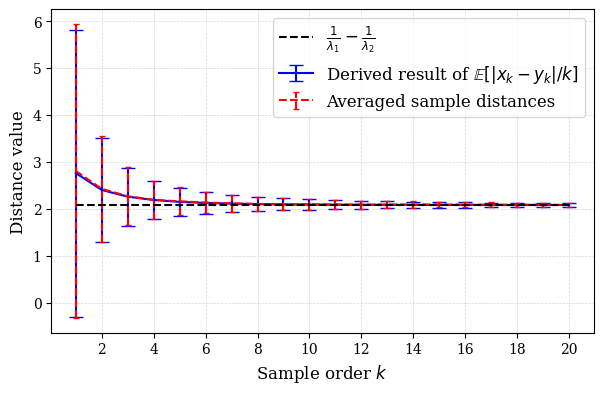

In [17]:
Ndisp = min(20, N)
plt.rc('font', family='serif')
plt.figure(figsize=(7,4.2))
Was_dists_array = np.abs(np.array(Was_dists))
Was_dists_std_array = np.abs(np.array(Was_dist_stds))
unif_Was_dists_array = np.abs(np.array(unif_Was_dists))

eb1 = plt.errorbar(np.arange(Ndisp)+1, Was_dists_array[:Ndisp]/(np.arange(Ndisp)+1), 
             yerr=Was_dists_std_array[:Ndisp]/(np.arange(Ndisp)+1)**2, c='b', label=r'Derived result of $\mathbb{E}[|x_k - y_k|/k]$', capsize=5)
eb2 = plt.errorbar(np.arange(Ndisp)+1, data_diffs_pois2_mean[:Ndisp]/(np.arange(Ndisp)+1), 
             yerr=data_diffs_pois2_std[:Ndisp]/(np.arange(Ndisp)+1)**2, c='r', ls='--', label='Averaged sample distances', capsize=2.5)
eb2[-1][0].set_linestyle('--')
plt.plot(np.arange(Ndisp)+1, (1/lambda1 - 1/lambda2)*np.ones(Ndisp), 'k--', label=r'$\frac{1}{\lambda_1} - \frac{1}{\lambda_2}$', zorder=5)

plt.xlabel(r'Sample order $k$', fontsize=12)
plt.ylabel(r'Distance value', fontsize=12)
plt.grid(True, linewidth=.5, alpha=0.5, linestyle='--')
plt.xticks([2*(i+1) for i in range(10)])
plt.legend(fontsize=12)
# plt.savefig(f'./fig_distance_validation.pdf', format='pdf', bbox_inches="tight", dpi=300)
plt.show()

In [18]:
lambda1s = np.linspace(1,5,51)
lambda2s = np.linspace(1,5,51)

In [19]:
def expected_was_dist(lambda1, lambda2, N):
    val = 0
    for n in range(N):
        val += exp_was_dist(n + 1, n + 1, lambda1, lambda2)
    return val/N

In [20]:
N = 20
# l1s, l2s = np.meshgrid(lambda1s, lambda2s)
expected_was = np.empty((len(lambda2s), len(lambda1s)))
for i, lambda1 in enumerate(lambda1s):
    for j, lambda2 in enumerate(lambda2s):
        expected_was[j,i] = expected_was_dist(lambda1, lambda2, N)


/tmp/ipykernel_1947/3866734072.py:10: RuntimeWarning: divide by zero encountered in divide
  temp_lambda2 = lambda1s/(2*lambda1s*c - 1)


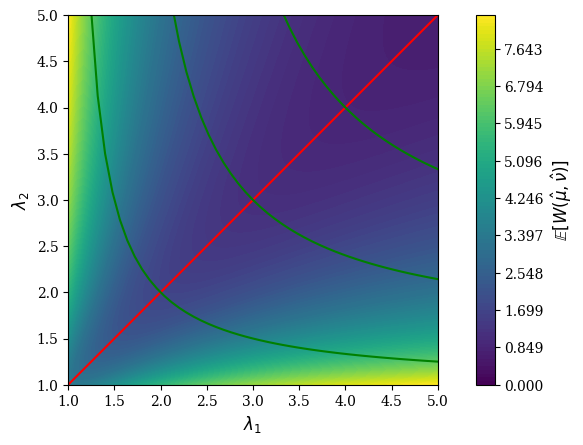

In [21]:
clev = np.linspace(0,expected_was.max(),100) 
h = plt.contourf(lambda1s, lambda2s, expected_was, clev)
cbar = plt.colorbar()
cbar.set_label(r'$\mathbb{E}[W(\hat{\mu}, \hat{\nu})]$', fontsize=12)
#plt.plot(w_list_np[:,0], w_list_np[:,1], c='orange', marker='o')
plt.plot(lambda1s, lambda2s, 'r')

cs = [1/2, 1/3, 1/4]
for c in cs:
    temp_lambda2 = lambda1s/(2*lambda1s*c - 1)
    plt.plot(lambda1s[temp_lambda2>lambda2s.min()], temp_lambda2[temp_lambda2>lambda2s.min()], 'g')
#plt.scatter(w_opt[0], w_opt[1], c='r', s=200, marker='*', zorder=10)
plt.axis('scaled')
plt.xlabel(r'$\lambda_1$', fontsize=12)
plt.ylabel(r'$\lambda_2$', fontsize=12)
plt.xlim([lambda1s.min(), lambda1s.max()])
plt.ylim([lambda2s.min(), lambda2s.max()])
plt.show()
# plt.savefig(f'./fig_WasDistance_validation.pdf', format='pdf', bbox_inches="tight", dpi=300)


/tmp/ipykernel_1947/778168929.py:10: RuntimeWarning: divide by zero encountered in divide
  temp_lambda2 = lambda1s/(2*lambda1s*c - 1)


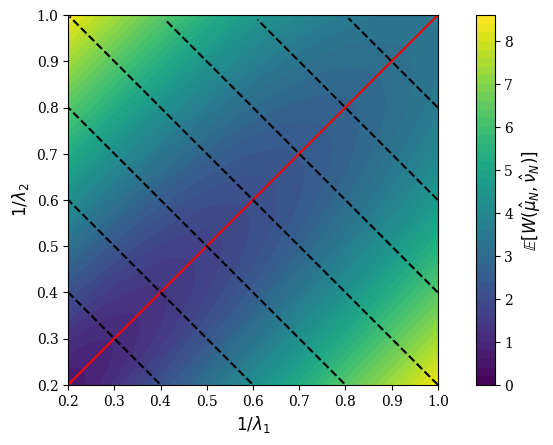

In [22]:
clev = np.linspace(0,8.6,44) 
h = plt.contourf(1/lambda1s, 1/lambda2s, expected_was, clev)
cbar = plt.colorbar()
cbar.set_label(r'$\mathbb{E}[W(\hat{\mu}_N, \hat{\nu}_N)]$', fontsize=12)
#plt.plot(w_list_np[:,0], w_list_np[:,1], c='orange', marker='o')
plt.plot(1/lambda1s, 1/lambda2s, 'r')

cs = np.linspace(0.1, 2.0, 20)
for c in cs:
    temp_lambda2 = lambda1s/(2*lambda1s*c - 1)
    plt.plot(1/lambda1s[temp_lambda2>lambda2s.min()], 1/temp_lambda2[temp_lambda2>lambda2s.min()], 'k--')
#plt.scatter(w_opt[0], w_opt[1], c='r', s=200, marker='*', zorder=10)
plt.axis('scaled')
plt.xlabel(r'$1/\lambda_1$', fontsize=12)
plt.ylabel(r'$1/\lambda_2$', fontsize=12)
plt.xlim([(1/lambda1s).min(), (1/lambda1s).max()])
plt.ylim([(1/lambda2s).min(), (1/lambda2s).max()])
# plt.savefig(f'./fig_WasDistance_validation.pdf', format='pdf', bbox_inches="tight", dpi=300)
plt.show()
